## Projeto: Reconhecimento de Sinais utilizando Rede Neural Convolucional

### Integrantes:
- Elder dos Santos Guedes Pereira

### Professor:
- Eduardo Simas


### Biblioteca

In [60]:
import tensorflow as tf

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from scipy.stats import zscore

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf

from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense, Activation


### DataSet

In [62]:
import kagglehub

# Realizando o download do dataset
path = kagglehub.dataset_download("maneesh99/signs-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/eldersgp/.cache/kagglehub/datasets/maneesh99/signs-detection-dataset/versions/2


In [63]:
train_data = h5py.File('Signs_Data_Training.h5')
test_data = h5py.File('Signs_Data_Testing.h5')

In [64]:
train_data.keys(), test_data.keys()

(<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>,
 <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>)

In [65]:
X_train = train_data['train_set_x']
Y_train = train_data['train_set_y']
X_test = test_data['test_set_x']
Y_test = test_data['test_set_y']

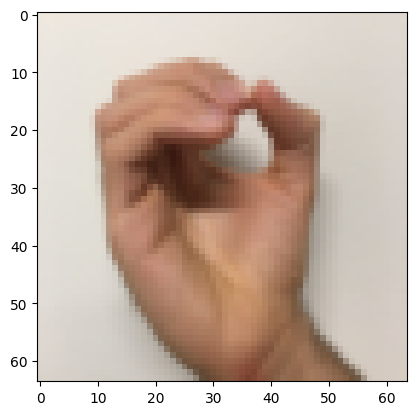

In [66]:
index = 1
plt.imshow(X_train[index])

In [67]:
# Alterando o modelo para array
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [68]:
X_train = X_train.reshape(1080, -1)
X_train = pd.DataFrame(X_train)

X_test = X_test.reshape(120, -1)
X_test = pd.DataFrame(X_test)

Y_train = pd.DataFrame(Y_train)

Y_test = pd.DataFrame(Y_test)

### Conhecendo os dados

In [69]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Columns: 12288 entries, 0 to 12287
dtypes: uint8(12288)
memory usage: 12.7 MB


In [70]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Columns: 12288 entries, 0 to 12287
dtypes: uint8(12288)
memory usage: 1.4 MB


In [71]:
X_train1 = train_data['train_set_x']
X_test1 = test_data['test_set_x']

X_train1

<HDF5 dataset "train_set_x": shape (1080, 64, 64, 3), type "|u1">

In [72]:
X_test1

<HDF5 dataset "test_set_x": shape (120, 64, 64, 3), type "|u1">

Vamos usar essas informações dos datasets para normalizar, tendo em vista que as redes neurais convolucionais funcionam melhor com valores em faixas menores e ajudar a evitar problemas númericos durante o treinamento.

In [73]:
#Normalização dos dados
X_train_norm = zscore(X_train)
X_train_norm = X_train_norm.values.reshape(1080, 64, 64, 3)

In [74]:
# Normalização dos dados de teste
X_test_norm = zscore(X_test)
X_test_norm = X_test_norm.values.reshape(120, 64, 64, 3)

### One-HOt

In [75]:
Y_train.columns = ['Label']

In [76]:
Y_test.columns = ['Label']

<Axes: ylabel='count'>

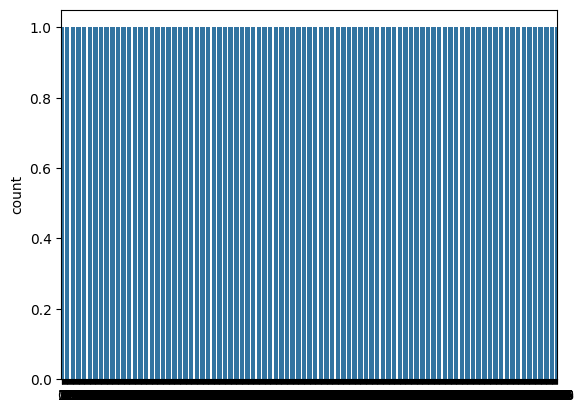

In [77]:
sns.countplot(Y_train['Label'])

In [78]:
Y_train_norm = pd.get_dummies(Y_train['Label'])
Y_train_norm.shape

(1080, 6)

In [79]:
Y_test_norm = pd.get_dummies(Y_test['Label']) 
Y_test_norm.shape

(120, 6)

### Modelo CNN

In [80]:
def create_model(input_shape, learning_rate=0.001):
    
    X_input = Input(input_shape)
    
    ## layer1
    X = Conv2D(32, (5,5), strides=(1,1), padding = 'same', activation='relu', name='Conv1')(X_input)
    X = MaxPool2D((2,2), name = 'Pool1')(X)
    X = Dropout(0.25)(X)
    
    ## layer2
    X = Conv2D(64, (5,5), strides=(1,1), padding = 'same', activation='relu', name='Conv2')(X)
    X = MaxPool2D((2,2), name = 'Pool2')(X)
    X = Dropout(0.25)(X)
    
    X = Flatten()(X)
    
    ## Fullly Connected
    X = Dense(256, activation = 'relu', name='fc1')(X)
    X = Dropout(0.25)(X)
    
    X = Dense(120, activation = 'relu', name='fc2')(X)
    X = Dropout(0.25)(X)
    
    ## Softmax layer
    X = Dense(6, activation = 'softmax', name='Output')(X)

    model = Model(inputs = X_input, outputs = X)
    
    ## Compile the model
    model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [81]:
M1 = create_model(X_train_norm.shape[1:])

### Treinamento

In [82]:
M1.fit(X_train_norm, Y_train_norm, epochs = 20, verbose=0)

In [83]:
Y_train_hat = M1.predict(X_train_norm)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [84]:
Y_train_hat = np.argmax(Y_train_hat, axis = 1)

In [91]:
print('Acurácia: ',round(accuracy_score(Y_train, Y_train_hat),4)*100,'%')

Acurácia:  99.72 %


In [92]:
Y_train_hat1 = M1.predict(X_test_norm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [93]:
Y_train_hat1 = np.argmax(Y_train_hat1, axis = 1)

print('Acurácia: ',round(accuracy_score(Y_test, Y_train_hat1),4)*100,'%')

Acurácia:  98.33 %


In [94]:
M1.save('model.h5')

## Aplicando o modelo em tempo real